## Pre Processing

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import gdown

gdown.download("https://drive.google.com/uc?id=1G0gt2jRu24yEgz4Ns2WRsjFHHlrFzKL_", output="creditcard.csv", quiet=False, fuzzy=True)


In [ ]:
data = pd.read_csv('creditcard.csv')

In [3]:
selected_features = ['V1', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V13', 'V14', 'V16', 'V17', 'V18', 'V20', 'V28']
X = data[selected_features]
y = data['Class']

In [ ]:
X_scaled_ = MinMaxScaler().fit_transform(X)
variances_array = np.var(X_scaled_, axis=0)
variance_dict = dict(zip(selected_features, variances_array))

top_features = sorted(variance_dict, key=variance_dict.get, reverse=True)[:10]

print("Top variance features:", top_features)

Top variance features: ['V13', 'V4', 'V11', 'V18', 'V9', 'V1', 'V14', 'V16', 'V17', 'V10']


In [5]:
X_scaled_ = MinMaxScaler().fit_transform(data[selected_features])
variances = np.var(X_scaled_, axis=0)

pd.DataFrame({
    'Feature': selected_features,
    'Variance': variances
}).sort_values(by='Variance', ascending=False)

,Feature,Variance
9,V13,0.005935
1,V4,0.003939
8,V11,0.003684
13,V18,0.003323
6,V9,0.001432
0,V1,0.001107
10,V14,0.001039
11,V16,0.000777
12,V17,0.000609
7,V10,0.000508


In [6]:
max_var = max(variance_dict.values())
min_var = min(variance_dict.values())
sensitivity_scale = {
    k: 0.5 + (v - min_var) / (max_var - min_var)  # scale to 0.5–1.5
    for k, v in variance_dict.items()
}

## LAPLACE

In [27]:
import numpy as np

def laplace_mechanism(data, sensitivity=1.0, epsilon=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale, data.shape)
    return data + noise


In [7]:
def laplace_with_scaled_sensitivity(X_df, epsilon, sensitivity_map):
    X_noised = X_df.copy()
    for col in sensitivity_map:
        scale = sensitivity_map[col] / epsilon
        noise = np.random.laplace(loc=0, scale=scale, size=X_df.shape[0])
        X_noised[col] += noise
    return np.clip(X_noised, 0, 1)

In [8]:
import numpy as np

def clip_percentiles_pandas(df, lower=1, upper=99):
    df_clipped = df.copy()
    for col in df.columns:
        low = np.percentile(df[col], lower)
        high = np.percentile(df[col], upper)
        df_clipped[col] = np.clip(df[col], low, high)
    return df_clipped

In [14]:
X_clipped = clip_percentiles_pandas(X, lower=1, upper=99)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_clipped)
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_features)

In [ ]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(kernel='rbf', class_weight='balanced', probability=True),
    'ANN': MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=200, random_state=42),
    'XGBoost': XGBClassifier(n_estimators = 100)
}

In [ ]:
epsilon_values = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]
all_results = []

In [ ]:
for epsilon in epsilon_values:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, stratify=y, random_state=42)

    X_train_noised = laplace_with_scaled_sensitivity(X_train, epsilon=epsilon, sensitivity_map=sensitivity_scale)

    for name, model in models.items():
        model.fit(X_train_noised, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        result = {
            'Model': name,
            'Epsilon': epsilon,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        }
        all_results.append(result)

        print(f"Model: {name} | Epsilon: {epsilon} | Acc: {acc:.5f} | Prec: {prec:.5f} | Rec: {rec:.5f} | F1: {f1:.5f}")
        
## Training takes 6 hours, don't re-run

In [16]:
result_laplace = pd.read_csv('Laplace 6 Models.csv')

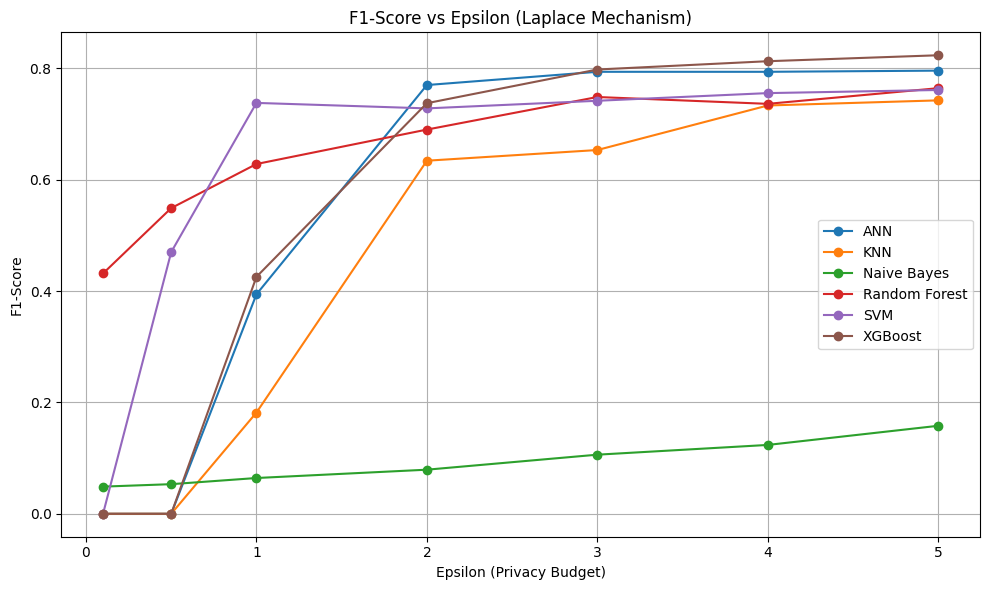

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for model_name in result_laplace['Model'].unique():
    model_data = result_laplace[result_laplace['Model'] == model_name]
    plt.plot(model_data['Epsilon'], model_data['F1-Score'], marker='o', label=model_name)

plt.title("F1-Score vs Epsilon (Laplace Mechanism)")
plt.xlabel("Epsilon (Privacy Budget)")
plt.ylabel("F1-Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
laplace_std = result_laplace.groupby('Epsilon')['F1-Score'].mean().std()

print("Laplace Std Dev:", laplace_std)


Laplace Std Dev: 0.2469594034677605


# PIECEWISE

In [ ]:
import numpy as np

def piecewise_mechanism(data, epsilon=1.0):
    d = data.shape[1]
    C = np.exp(epsilon / 2) / (np.exp(epsilon / 2) + 1)
    data_perturbed = np.copy(data)

    for i in range(data.shape[0]):
        for j in range(d):
            original = data[i, j]
            r = np.random.uniform(0, 1)

            if r <= C:
                low = max(-1, original - 0.2)
                high = min(1, original + 0.2)
                data_perturbed[i, j] = np.random.uniform(low, high)
            else:
                midpoint = 0.5
                if original < midpoint:
                    data_perturbed[i, j] = np.random.uniform(midpoint + 0.3, 1.0)
                else:
                    data_perturbed[i, j] = np.random.uniform(-1.0, midpoint - 0.3)
    return data_perturbed

In [ ]:
selected_features = ['V1', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V13', 'V14', 'V16', 'V17', 'V18', 'V20', 'V28']
X = data[selected_features]
y = data['Class'].values

X_clipped = clip_percentiles_pandas(X, lower=1, upper=99)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_clipped)

In [ ]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(kernel='rbf', class_weight='balanced', probability=True),
    'ANN': MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=200, random_state=42),
    'XGBoost': XGBClassifier(n_estimators = 100)
}

In [ ]:
# Apply Piecewise mechanism
epsilon_values = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]
all_results = []

In [ ]:
for epsilon in epsilon_values:
    X_noised = piecewise_mechanism(X_scaled, epsilon=epsilon)

    X_train, X_test, y_train, y_test = train_test_split(
        X_noised, y, test_size=0.2, stratify=y, random_state=42
    )

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        all_results.append({
            'Model': name,
            'Epsilon': epsilon,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        })

In [ ]:
import pandas as pd
results_df = pd.DataFrame(all_results)
results_df.sort_values(by=['Epsilon', 'Model'], inplace=True)
results_df

In [30]:
result_piecewise = pd.read_csv('Piecewise 6 Models.csv')

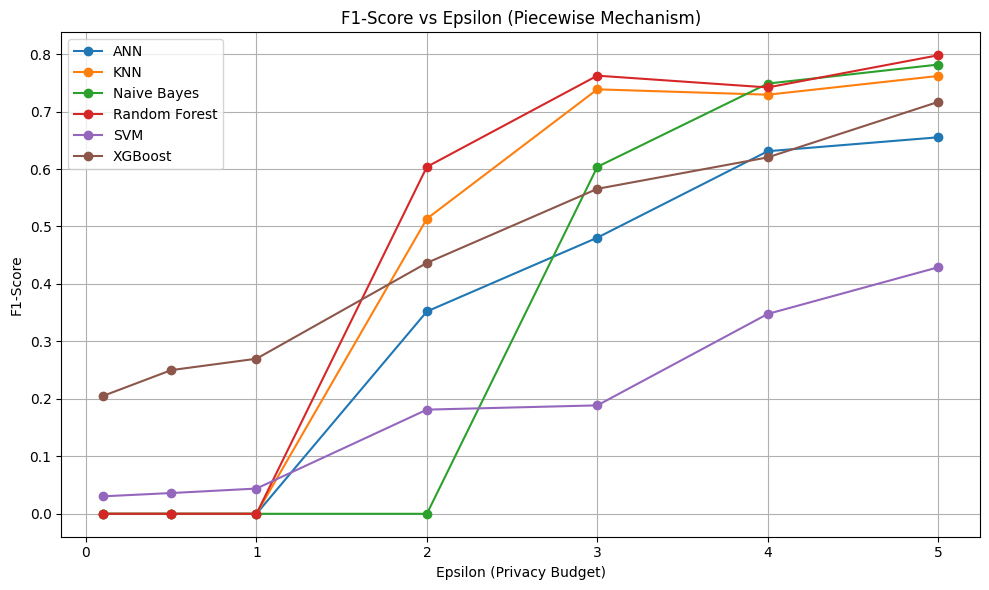

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for model_name in result_piecewise['Model'].unique():
    model_data = result_piecewise[result_piecewise['Model'] == model_name]
    plt.plot(model_data['Epsilon'], model_data['F1-Score'], marker='o', label=model_name)

plt.title("F1-Score vs Epsilon (Piecewise Mechanism)")
plt.xlabel("Epsilon (Privacy Budget)")
plt.ylabel("F1-Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
piecewise_std = result_piecewise.groupby('Epsilon')['F1-Score'].mean().std()

print("Piecewise Std Dev:", piecewise_std)


Piecewise Std Dev: 0.29335042161727737


# DUCHI

In [ ]:
def duchi_mechanism_cpu(data_np, epsilon, num_candidates=100):
    n, d = data_np.shape
    k = max(1, min(d, int(np.ceil(epsilon / 2.5))))
    B = d / k

    probs = 0.5 + 0.5 * data_np
    rand = np.random.rand(n, d)
    v = np.where(rand < probs, 1, -1)

    candidates = np.random.choice([-B, B], size=(num_candidates, d))
    dot_products = candidates @ v.T  

    T_plus_mask = dot_products > 0
    T_minus_mask = dot_products < 0

    rand_vals_plus = np.random.rand(num_candidates, n)
    rand_vals_plus[~T_plus_mask] = -1.0
    sampled_T_plus_idx = np.argmax(rand_vals_plus, axis=0)

    rand_vals_minus = np.random.rand(num_candidates, n)
    rand_vals_minus[~T_minus_mask] = -1.0
    sampled_T_minus_idx = np.argmax(rand_vals_minus, axis=0)

    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    u = np.random.rand(n) < p

    final_idx = np.where(u, sampled_T_plus_idx, sampled_T_minus_idx)
    perturbed = candidates[final_idx]

    return np.clip(perturbed, -1, 1)

In [9]:
selected_features = ['V13', 'V4', 'V11', 'V18', 'V9', 'V1', 'V14', 'V16', 'V17', 'V10']
X = data[selected_features].copy()
y = data['Class'].astype(int).values

In [10]:
for col in X.columns:
    low = X[col].quantile(0.01)
    high = X[col].quantile(0.99)
    X[col] = X[col].clip(lower=low, upper=high)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
fraud_idx = np.where(y_train == 1)[0]
normal_idx = np.where(y_train == 0)[0]
np.random.shuffle(normal_idx)
normal_idx = normal_idx[:len(fraud_idx) * 4]
balanced_idx = np.concatenate([fraud_idx, normal_idx])
np.random.shuffle(balanced_idx)

X_train_bal = X_train[balanced_idx]
y_train_bal = y_train[balanced_idx]


In [ ]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(kernel='rbf', class_weight='balanced', probability=True),
    'ANN': MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=200, random_state=42),
    'XGBoost': XGBClassifier(n_estimators = 100)
}

epsilon_values = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]
all_results = []

In [ ]:
for epsilon in epsilon_values:
    X_train_noised = duchi_mechanism_cpu(X_train_bal, epsilon)
    X_train_noised = np.clip(X_train_noised, -0.8, 0.8)

    for name, model in models.items():
        model.fit(X_train_noised, y_train_bal)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        all_results.append({
            'Model': name,
            'Epsilon': epsilon,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        })

results_df = pd.DataFrame(all_results)
print(results_df.sort_values(by=["Epsilon", "F1-Score"], ascending=[True, False]))

## Training takes 5 hours, don't re-run

In [ ]:
import pandas as pd
results_df = pd.DataFrame(all_results)
results_df.sort_values(by=['Epsilon', 'Model'], inplace=True)
results_df

In [25]:
result_duchi = pd.read_csv('Duchi 6 Models.csv')

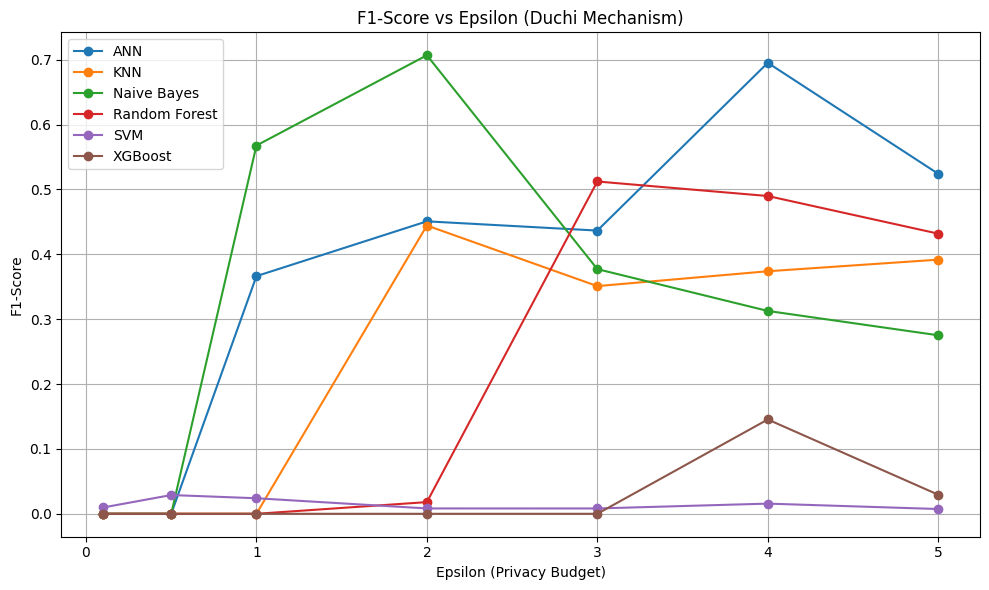

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for model_name in result_duchi['Model'].unique():
    model_data = result_duchi[result_duchi['Model'] == model_name]
    plt.plot(model_data['Epsilon'], model_data['F1-Score'], marker='o', label=model_name)

plt.title("F1-Score vs Epsilon (Duchi Mechanism)")
plt.xlabel("Epsilon (Privacy Budget)")
plt.ylabel("F1-Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Filter per mechanism and compute standard deviation of F1-Score across all ε
duchi_std = result_duchi.groupby('Epsilon')['F1-Score'].mean().std()

print("Duchi Std Dev:", duchi_std)


Duchi Std Dev: 0.12311391968622643


# RESULTS